In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import seaborn as sns

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
# Use Tensorboard for network visualization & debugging
from tensorflow.keras.callbacks import TensorBoard
import sklearn.metrics
# import regularizer(s)
from tensorflow.keras.regularizers import l1, l2, l1_l2
# import Dropout
from tensorflow.keras.layers import Dropout
# import activation seperately
from tensorflow.keras.layers import Activation

In [59]:
V52_data = pd.read_csv('V52_data_filledM1.csv')
# make Date the index in datetime format
V52_data.index = pd.to_datetime(V52_data['Date'], format='%Y%m%d%H%M')



## EXTRACT THE LONGEST 3 SEQUENCES WITHOUT NANS

In [61]:
missing_values = V52_data['Wsp_44m'].isnull()

# Create groups based on consecutive non-NaN values
groups = missing_values.ne(missing_values.shift()).cumsum()

# Count occurrences within groups
sequence_lengths = V52_data.groupby(groups)['Wsp_44m'].transform('count')

# Get the top three longest sequences
top_three_sequences = sequence_lengths.groupby(groups).max().nlargest(3)

# Extract the periods for the top three sequences
for sequence_length in top_three_sequences.index:
    sequence_mask = (groups == sequence_length) & ~missing_values
    sequence_period = V52_data.index[sequence_mask]
    print(f"Sequence Length: {sequence_length}, Period: {sequence_period}")

Sequence Length: 317, Period: DatetimeIndex(['2018-07-17 10:40:00', '2018-07-17 10:50:00',
               '2018-07-17 11:00:00', '2018-07-17 11:10:00',
               '2018-07-17 11:20:00', '2018-07-17 11:30:00',
               '2018-07-17 11:40:00', '2018-07-17 11:50:00',
               '2018-07-17 12:00:00', '2018-07-17 12:10:00',
               ...
               '2018-07-26 17:50:00', '2018-07-26 18:00:00',
               '2018-07-26 18:10:00', '2018-07-26 18:20:00',
               '2018-07-26 18:30:00', '2018-07-26 18:40:00',
               '2018-07-26 18:50:00', '2018-07-26 19:00:00',
               '2018-07-26 19:10:00', '2018-07-26 19:20:00'],
              dtype='datetime64[ns]', name='Date', length=1349, freq=None)
Sequence Length: 505, Period: DatetimeIndex(['2018-11-27 18:50:00', '2018-11-27 19:00:00',
               '2018-11-27 19:10:00', '2018-11-27 19:20:00',
               '2018-11-27 19:30:00', '2018-11-27 19:40:00',
               '2018-11-27 19:50:00', '2018-11-27 20

In [62]:
# Assume 'var1', 'var2' are the names of the additional variables you want to save
top_three_dataframes = []
for sequence_length in top_three_sequences.index:
    sequence_mask = (groups == sequence_length) & ~missing_values
    sequence_data = V52_data[sequence_mask][['Wsp_44m', 'Wsp_44m_std', 'ActPow','ActPow_std']]
    sequence_index = V52_data[sequence_mask].index
    sequence_df = pd.DataFrame(sequence_data, index=sequence_index)
    top_three_dataframes.append(sequence_df)

# Display the top three DataFrames
for idx, dataframe in enumerate(top_three_dataframes, start=1):
    print(f"DataFrame {idx}:")
    print(dataframe)
    # save each data frame so it can be used in the next step
    dataframe.to_csv(f"sequence_{idx}.csv")


DataFrame 1:
                     Wsp_44m  Wsp_44m_std   ActPow  ActPow_std
Date                                                          
2018-07-17 10:40:00  4.39173     0.875036  10.4617     25.2427
2018-07-17 10:50:00  4.39173     0.875036  10.4617     25.2427
2018-07-17 11:00:00  4.39173     0.875036  10.4617     25.2427
2018-07-17 11:10:00  4.39173     0.875036  10.4617     25.2427
2018-07-17 11:20:00  4.39173     0.875036  10.4617     25.2427
...                      ...          ...      ...         ...
2018-07-26 18:40:00  4.99079     1.002880  54.5495     31.7622
2018-07-26 18:50:00  5.03892     0.892508  60.0681     27.4009
2018-07-26 19:00:00  4.77209     0.784662  28.1651     18.4547
2018-07-26 19:10:00  4.47289     0.730325  24.2656     19.7536
2018-07-26 19:20:00  3.88335     0.664703  15.3370     14.6744

[1349 rows x 4 columns]
DataFrame 2:
                     Wsp_44m  Wsp_44m_std    ActPow  ActPow_std
Date                                                           
20

In [63]:
#import 
sequence_1 = pd.read_csv('sequence_1.csv')
sequence_2 = pd.read_csv('sequence_2.csv')
sequence_3 = pd.read_csv('sequence_3.csv')

## With a continous data set we can begin a LSTM model

## Additional info on the time series processing - things to watch out!
1. **Non-stationary data** 
<br>‘Stationarity’ is one of the most important concepts you will come across when working with time series data. A stationary series is one in which the properties – mean, variance and covariance, **do not** vary with time.
<br>  Always keep in mind that in order to use time series forecasting models, it is necessary to convert any non-stationary series to a stationary series first. There are mainly two ways to do this:
     <br> 1.1 ***Differencing (one or multiple steps)***   $\rightarrow y_{diff}=y_{t}-y_{t-n} $ Pandas diff can directly be used or you can use df.shift(n) to extract $y_{t-n}$ 
     <br> 1.2 ***Axis transformations*** $\rightarrow$ e.g. log-transform can also help depending on your data. Also note that you can repeat the differencing several times until you reach the 'desired' stationarity.
2. **Scaling**
<br>As discussed (and demonstrated) above.
3. **LSTM particular input shape**
<br> Think thorough on samples, timesteps, features and what they represent for your data and problem at hand. In general, it goes as "how many features you would like to feed into the model at a time (timesteps) and how many of those sequences do you have? Let's do an example for our forecasting problem at hand...
3. **Inverse transform the output**
<br> Different than 'just' a binary classification, the output of your model might have units and non-stationary structure as well. Remember to inverse transform of your model predictions to deliver the 'true value' of your outputs.

## Divide Time series into Sequences
We will define 2 useful functions that will generate sequences of input + output intervals.

* The input interval is based on how much further back you would like to add to the memory
* The output interval depends on the forecast horizon for your problem


The input interval is one of the *hyperparameters* to tune. We can start with an initial guess and adjust it to see if we can get a performance increase.

In [64]:
### define a function that will prepare the shifting input sequences for the network
def forecast_sequences_input(input_data, n_lag):
    """
    A function that will split the input time series to sequences for nowcast/forecast problems
    Arguments:
        input_data: Time series of input observations as a list, NumPy array or pandas series
        n_lag: number of previous time steps to use for training, a.k.a. time-lag        
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = input_data.shape[1] 
    df = pd.DataFrame(input_data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg


### define a function that will prepare the shifting output sequences of the network
def forecast_sequences_output(output_data,n_out):
    """
    A function that will split the output time series to sequences for nowcast/forecast problems
    Arguments:
        output_data: Time series of input observations as a list, NumPy array or pandas series
        n_out: forecast horizon (for multi-output forecast)
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = output_data.shape[1] 
    df = pd.DataFrame(output_data)
    cols, names = list(), list()
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names    
    return agg


### Define length of the input and output intervals within the sequences

In [65]:
n_lag = 6 # number of previous time steps to use for training, a.k.a. time-lag
n_out = 1  # forecast hoizon: number of next time steps we will predict 1 = the next 10-min mean

### Define training, validation and test data as before, let's use dataframes this time
INPUTS:   
   1. Power
   2. std of power

OUTPUT:
   1. future power 


In [66]:
### Split data into train & test 
train_int = int(len(sequence_2))      # 60% of the data length for training
validation_int = int(len(sequence_3)) # 20% more for validation

# training input vector
X_train = sequence_2[['Wsp_44m', 'Wsp_44m_std']]
X_train = forecast_sequences_input(X_train ,n_lag)

# training output vector
Y_train = sequence_2[['ActPow']][:]
Y_train = forecast_sequences_output(Y_train, n_out)

# validation input vector
X_validation = sequence_3[['Wsp_44m', 'Wsp_44m_std']][:]
X_validation = forecast_sequences_input(X_validation,n_lag)

# validation output vector
Y_validation = sequence_3[['ActPow']][:]
Y_validation = forecast_sequences_output(Y_validation, n_out)

# test input vector
X_test = V52_data[['Wsp_44m', 'Wsp_44m_std']][:10000]
X_test = forecast_sequences_input(X_test,n_lag)

# test output vector
Y_test = V52_data[['ActPow']][:10000]
Y_test = forecast_sequences_output(Y_test, n_out)

In [67]:
X_train

,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.70978,0.378058
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.70978,0.378058,3.70978,0.378058
3,NaN,NaN,NaN,NaN,NaN,NaN,3.70978,0.378058,3.70978,0.378058,3.70978,0.378058
4,NaN,NaN,NaN,NaN,3.70978,0.378058,3.70978,0.378058,3.70978,0.378058,3.70978,0.378058
...,...,...,...,...,...,...,...,...,...,...,...,...
1268,5.24182,0.957452,4.93079,0.693905,5.44116,0.512027,4.96408,0.602155,4.36295,0.703402,4.50616,0.709216
1269,4.93079,0.693905,5.44116,0.512027,4.96408,0.602155,4.36295,0.703402,4.50616,0.709216,5.25261,0.640325
1270,5.44116,0.512027,4.96408,0.602155,4.36295,0.703402,4.50616,0.709216,5.25261,0.640325,5.01989,0.602097
1271,4.96408,0.602155,4.36295,0.703402,4.50616,0.709216,5.25261,0.640325,5.01989,0.602097,4.63983,0.469522


In [68]:
Y_train

,var1(t)
0,9.98641
1,9.98641
2,9.98641
3,9.98641
4,9.98641
...,...
1268,63.12580
1269,65.21770
1270,42.32730
1271,28.86860


### Remember to scale!

In [69]:
from sklearn.preprocessing import MinMaxScaler
### scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

Y_train_scaled = scaler.fit_transform(Y_train)
Y_validation_scaled = scaler.transform(Y_validation)
Y_test_scaled = scaler.transform(Y_test)

print('Training input (samples, timesteps):', X_train_scaled.shape)
print('Training output (samples, timesteps):', Y_train.shape)
print('Validation input (samples, timesteps):', X_validation_scaled.shape)
print('Validation output (samples, timesteps):', Y_validation.shape)

Training input (samples, timesteps): (1273, 12)
Training output (samples, timesteps): (1273, 1)
Validation input (samples, timesteps): (948, 12)
Validation output (samples, timesteps): (948, 1)


### Pad NaNs for missing periods with a significant number (to be 'masked' for the training later)

In [70]:
pad_value = 999

X_train_scaled[np.isnan(X_train_scaled)] = pad_value
X_validation_scaled[np.isnan(X_validation_scaled)] = pad_value
X_test_scaled[np.isnan(X_test_scaled)] = pad_value

In [71]:
X_train_scaled

array([[9.99000000e+02, 9.99000000e+02, 9.99000000e+02, ...,
        9.99000000e+02, 9.99000000e+02, 9.99000000e+02],
       [9.99000000e+02, 9.99000000e+02, 9.99000000e+02, ...,
        9.99000000e+02, 9.92535803e-02, 8.65660712e-02],
       [9.99000000e+02, 9.99000000e+02, 9.99000000e+02, ...,
        8.65660712e-02, 9.92535803e-02, 8.65660712e-02],
       ...,
       [2.08091054e-01, 1.47126338e-01, 1.78100999e-01, ...,
        2.05123047e-01, 1.81609310e-01, 1.87842199e-01],
       [1.78100999e-01, 1.87868418e-01, 1.40312951e-01, ...,
        1.87842199e-01, 1.57718095e-01, 1.27912086e-01],
       [1.40312951e-01, 2.33636807e-01, 1.49315373e-01, ...,
        1.27912086e-01, 1.30395890e-01, 1.70716404e-01]])

## LSTM architecture

We will first add a Masking layer to tell the network to ignore missing periods in the training
 
We will use pretty much the same architecture with FFNN, except for the LSTM layers. 

There are however, little differences LSTM requires in bulding the model.

In [72]:
from tensorflow.keras.layers import LSTM, Masking

# for multiple model creation - clear  the previous DAG
K.clear_session() 

### Input reshape for LSTM problem  [samples, timesteps, features]
no_features = 2 # Avg and Std of wind speed

train_X = X_train_scaled.reshape((X_train_scaled.shape[0], n_lag, no_features))#.astype('float32')
train_Y = Y_train_scaled #.values#.astype('float32')

validation_X = X_validation_scaled.reshape((X_validation_scaled.shape[0], n_lag, 2))#.astype('float32')
validation_Y = Y_validation_scaled #.values#.astype('float32')

test_X = X_test_scaled.reshape((X_test_scaled.shape[0], n_lag, 2))#.astype('float32')
test_Y = Y_test_scaled #.values#.astype('float32')


In [73]:

### create model
model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))

# First LSTM layer
model.add(LSTM(50, 
               return_sequences=True,  # important to add it to ensure the following LSTM layers will have the same input shape
               input_shape=(train_X.shape[1], train_X.shape[2]),                
               kernel_initializer='random_uniform',
               bias_initializer='zeros'))
               
# then we add the activation
model.add(Activation('relu'))

# Second LSTM layer
model.add(LSTM(10, activation='relu'))

# Output Layer
model.add(Dense(1, activation='relu'))
model.summary()

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# fit the model and store the graphs and performance to be used in TensorBoard (optional)
now = datetime.datetime.now().strftime("%Y%m%d%H%M")

tbGraph = TensorBoard(log_dir=f'.\Graph\{now}',
                      histogram_freq=64*2, write_graph=True, write_images=True)

history = model.fit(train_X, train_Y, 
          epochs=30,
          batch_size=64,
          validation_data=(validation_X, validation_Y),
          callbacks=[tbGraph])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 2)           0         
                                                                 
 lstm (LSTM)                 (None, None, 50)          10600     
                                                                 
 activation (Activation)     (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                2440      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 13051 (50.98 KB)
Trainable params: 13051 (50.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
20/20 [==

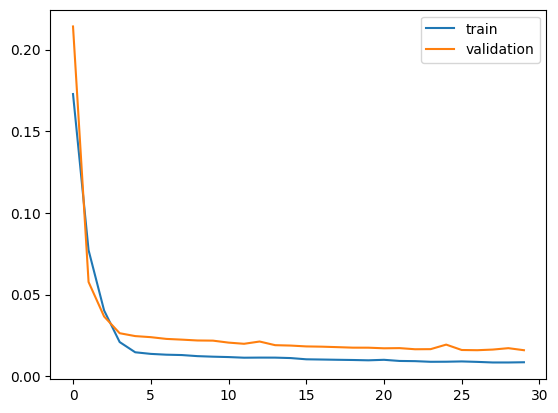

In [74]:
# plot the lost
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.legend()

313/313 [==============================] - 3s 5ms/step


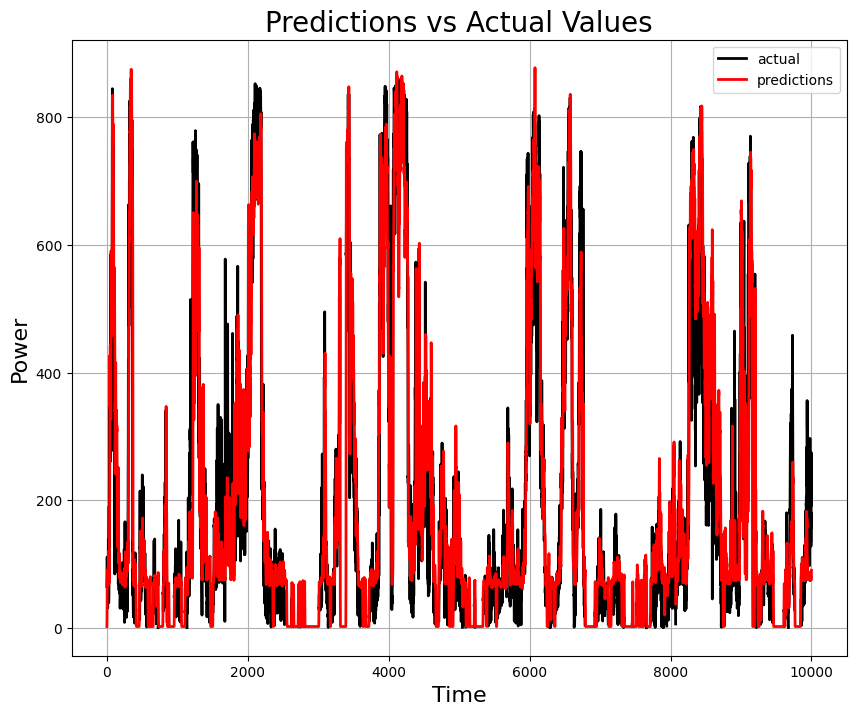

In [75]:
# Make predictions and plot them against the actual values
predictions = model.predict(test_X)
predictions = scaler.inverse_transform(predictions)
test_Y = scaler.inverse_transform(test_Y)
# plot the predictions
plt.figure(figsize=(10,8))

plt.plot(test_Y, 'k', label='actual', linewidth=2)
plt.plot(predictions,'-r', label='predictions', linewidth=2)
plt.grid(True)

plt.title('Predictions vs Actual Values', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Power', fontsize=16)

plt.legend()